# 1. Проблемы с исходными данными
1.1 В колонках Точка_росы_Этап1_зона1 и Точка_росы_Этап1_зона2 данные чередуются. Предлагаю объединить. Тоже самое в колонках CO_Этап1_зона1 и CO_Этап1_зона2

1.2 Есть колонки, в которых содержится 1 уникальное значение - удаляем

1.3 Время входа/выхода в технологическую секцию и начала/окончания технологического отжига есть не во всех строчках. Время общее для всех строчек из одной плавки. Поэтому предлагаю заменить на время процесса = выход -  вход

1.4 В колонке "Толщина_перед_смоткой" присутствуют строковые данные. Нужно оставить только  числа.

1.5 Присутствуют колонки типа 'object', в которых содержаться численные данные. Необходимо преобразовать в тип float

1.6 Присутствуют колонки с категориальными данными, необходимо сделать encoding

1.7 Колонки с общими данными не влияют на результат тех процесса. Удаляем




In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [125]:
!pip install joblib
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import os
import random
import joblib
from tqdm import tqdm

from sklearn import utils
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve, classification_report, confusion_matrix,roc_auc_score, roc_curve, precision_recall_fscore_support, f1_score
from sklearn.metrics import roc_auc_score

from scipy import stats

pd.set_option('display.max_columns', None)

In [3]:
y_label = 'Удельные_потери'
Y_LIMIT = 1.1

In [4]:
info = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/IBS/Описание параметров.csv', encoding='cp1251' )
info

,Название параметра,Этап обработки,Описание
0,Длина_ГП,Горячий прокат,Фактическая длина на этапе горячей прокатки
1,T_за_средней_клетью,Горячий прокат,Замеры температур
2,T_конца_проката,Горячий прокат,Замеры температур
3,T_рулона,Горячий прокат,Замеры температур
4,Толщина_перед_смоткой,Горячий прокат,Замер толщины
...,...,...,...
115,T_проход_5,Холодный прокат,Замер температуры рулона
116,T_проход_2,Холодный прокат,Замер температуры рулона
117,T_проход_4,Холодный прокат,Замер температуры рулона
118,Температура_полосы_на_выходе_реверсивного стана,Холодный прокат,Замер температуры рулона


In [5]:
# Этапы обработки
hot_rolling = info[info['Этап обработки'] == 'Горячий прокат']['Название параметра'].to_list()
normalization = info[info['Этап обработки'] == 'Нормализация']['Название параметра'].to_list()
c_remove = info[info['Этап обработки'] == 'Обезуглероживание']['Название параметра'].to_list()
chem_init = info[info['Этап обработки'] == 'Химия плавки']['Название параметра'].to_list()
chem_end = info[info['Этап обработки'] == 'Химия итог']['Название параметра'].to_list()
cold_rolling = info[info['Этап обработки'] == 'Холодный прокат']['Название параметра'].to_list()
magnetic_char = info[info['Этап обработки'] == 'Магнитные свойства']['Название параметра'].to_list()
magnetic_char.remove(y_label)
main_info = info[info['Этап обработки'] == 'Общие данные']['Название параметра'].to_list()

In [6]:
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/IBS/Dataset.csv')
data

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (49,115) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,Индекс,Номер партии,Номер партии_АСУТП,Номер плавки,Номер рулона,Длина_1,Длина_2,Длина_3,Длина_4,Длина_5,Углерод_начало,Длина_Обезуглероживание,Толщина_средняя,Длина_ГП,Длина_МС,Длина_Н,Азот_конец,Азот_начало,Азот_среднее,Кислород_начало,N,Al,Номер_бригады,Поступление_в_технологическую_секцию,Выезд_из_технологической_секции,Длина__м,ЗВО,CO_Этап2_зона1,CO_Этап2_зона2,CO_Этап2_зона3,CO_Этап2_зона4,CO2_Этап1,Калиброванное_значение_CO2_Этап2_зона4,Si,Mn,Cu,NH3_Этап3_зона3,T_Этап3_зона4,Настройка_датчика_CO2_Этап2_зона4,Ni,Кислород_конец,Кислород_среднее,Sn,Средние_магнитные_потери,Коэффициент_свойств_стали,S,Датчик_механических_свойств,Углерод_конец,H2_Этап3_зона3,Скорость_технологической_секции,H2_Этап4_зона1,H2_Этап2_зона1,H2_Этап2_зона2,H2_Этап2_зона3,H2_Этап2_зона4,H2_Этап3_зона1,H2_Этап3_зона2,NH3_Этап3_зона1,NH3_Этап3_зона2,CO_Этап2_зона5,T_Этап1_зона6,Углерод_среднее,Т_Этап5_зона1,Т_Этап5_зона2,Т_Этап4_зона1,Т_Этап4_зона2,T_Этап1_зона1,T_Этап1_зона2,T_Этап1_зона3,T_Этап1_зона4,T_Этап1_зона5,T_Этап2_зона1,T_Этап2_зона2,T_Этап2_зона3,T_Этап2_зона4,T_Этап2_зона5,T_Этап2_зона6,T_Этап2_зона7,T_Этап3_зона1,T_Этап3_зона2,T_Этап3_зона3,T_в_начале_нормализации,T_в_середине_нормализации_1,T_в_середине_нормализации_2,T_в_конце_нормализации,T_проход_1,T_проход_3,T_проход_5,T_проход_2,T_проход_4,Температура_полосы_на_выходе_реверсивного стана,ШОС,Ti,Длина_Азотирование,Толщина_МС,Точка_росы_Этап4_зона1,Точка_росы_Этап2_зона2,Точка_росы_Этап2_зона3,T_за_средней_клетью,T_конца_проката,T_рулона,Тренд_температуры_перед_реверсивным_станом,Толщина_перед_смоткой,C,Удельные_потери,Начало непрерывного отжига,Окончание непрерывного отжига,F,Cr,Водород_начало,Водород_среднее,CO2_Этап2_зона5,H2_Этап2_зона5,Точка_росы_Этап1_зона1,Точка_росы_Этап1_зона2,CO_Этап1_зона1,CO_Этап1_зона2,H2_Этап1,CO2_Этап2_зона1,CO2_Этап2_зона3
0,0,522350,580797,1717428,70,"23,28",2214,"55,6","5111,88","121,76","0,0027","121,12",25,"46,32",120,"25,2","0,023","0,022","0,0225","0,091","0,0083","0,028",1,2017-08-01 13:23:14,NaN,"0,016","3,5","1,73","1,15","0,46","0,21","0,11","-0,02","3,315","0,14","0,01","0,1501156362",309,0,"0,01",0.0875,"0,08925","0,003","1,04",1,"0,005","35,80168","0,0025","0,1020408163",68,"51,69","69,17","68,23","65,46","53,39",36,"18,70496","0,03","0,96","1,570693878",0,"0,0026","747,84448","745,99","839,96","839,57552","930,18","929,64","909,09992","900,0412","868,47","839,90224","839,9","840,42208","839,81","839,19776",839.522240,"839,3256","770,44","769,47112","771,61576","1097,4032","1098,0032","1091,0952","902,1128","135,6911704","181,605608","199,7500384","178,91038","191,5273",100,Melubir 6736/LI,"0,002",3560,"0,287","-19,86","61,00448","59,75328","948,368","922,7870476","593,184381",364,"тренд 2,3","0,055","1,072",NaN,2017-08-01 14:07:58,"0,024","0,11","2,4","1,7","1,22","69,7",NaN,"63,68",NaN,"1,6","69,75","0,1","0,06"
1,1,522350,580797,1717428,70,"25,22",2211,"60,23333333","5104,953333","131,9066667","0,0027","131,2133333",25,"47,68",130,"27,3","0,023","0,022","0,0225","0,091","0,0083","0,028",1,2017-08-01 13:23:14,2017-08-01 14:07:58,"0,0173333333","3,5","1,73","1,15","0,46","0,21","0,11","0,8214709848","3,315","0,14","0,01","0,756901005",25,"0,8414709848","0,01",0.0875,"0,08925","0,003","1,04",1,"0,005","42,80209333","0,0025","0,1020408163",68,"51,69","69,17","68,23","65,46","53,39",36,"14,9254","0,03","0,96","1,570502986",0,"0,0026","747,88","745,9924267","839,9624267","839,5387867","930,1775733","929,64","909,02","900,1457733","868,47","839,9212133","839,9084933","840,2848533","839,81","839,1812133",839.524227,"839,35908","770,44","769,4884933","771,83092","1097,4368","1098,0368","1091,0448","902,2472","136,5621044","183,547782","200,2143333","179,18122","193,1751",100,Melubir 6736/LI,"0,002",3680,"0,288","-19,86","61,03514667","59,69029333","948,232","922,8129524","591,215619",364,"тренд 2,3","0,055","1,087",NaN,NaN,"0,024","0,11","2,7","1,9","1,22","70,8",NaN,"63,68",NaN,"1,6","69,75","0,1","0,06"
2,2,522350,580797,1717428,70,"27,16",2

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12791 entries, 0 to 12790
Columns: 120 entries, Индекс to CO2_Этап2_зона3
dtypes: float64(2), int64(14), object(104)
memory usage: 11.7+ MB


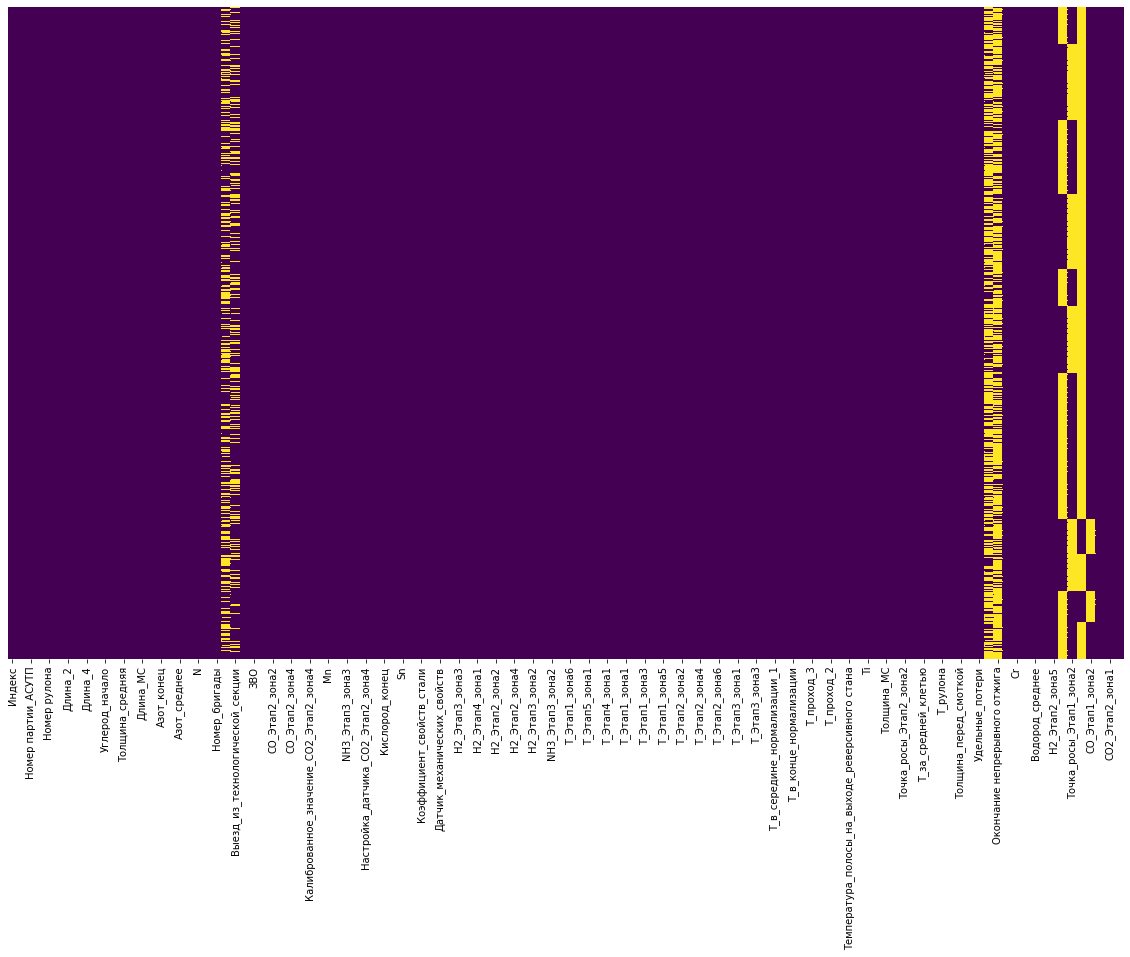

In [8]:
# Смотрим пропущенные данные
def visual_check(data):
  fig, ax = plt.subplots(figsize=(20,12))
  sns_heatmap = sns.heatmap(data.isnull(), yticklabels=False, cbar=False, cmap='viridis')
  plt.show()

visual_check(data)

In [9]:
# Соединяем колонки
data.loc[data['Точка_росы_Этап1_зона1'].isnull(), 'Точка_росы_Этап1_зона1'] = data['Точка_росы_Этап1_зона2']
del data['Точка_росы_Этап1_зона2']
data.loc[data['CO_Этап1_зона1'].isnull(), 'CO_Этап1_зона1'] = data['CO_Этап1_зона2']
del data['CO_Этап1_зона2']
# Дублируются в 'Начало непрерывного отжига', 'Окончание непрерывного отжига'
del data['Поступление_в_технологическую_секцию'], data['Выезд_из_технологической_секции']  

In [10]:
# Функция заполнения пропущенного времени
def fill_na_time(group_value, fill_col, group_col='Номер плавки'):
  data[fill_col] = data[fill_col].fillna(0)
  unique = data[data[group_col] == group_value][fill_col].unique()
  unique = np.delete(unique, np.argwhere(unique == 0))
  data.loc[data[group_col] == m, fill_col] = unique[0]

# Заполняем время
time_columns = ['Начало непрерывного отжига', 'Окончание непрерывного отжига']
melt = data['Номер плавки'].unique()
for col in time_columns:
  for m in melt:
    fill_na_time(m, col)
  data[col] = pd.to_datetime(data[col])

# Поучаем разницу времени в секундах
data['c_time_diff'] = data['Окончание непрерывного отжига'] - data['Начало непрерывного отжига']
data['c_time_diff'] = pd.to_timedelta(data['c_time_diff'], unit='s').dt.total_seconds().astype(int)
del data['Окончание непрерывного отжига'], data['Начало непрерывного отжига']

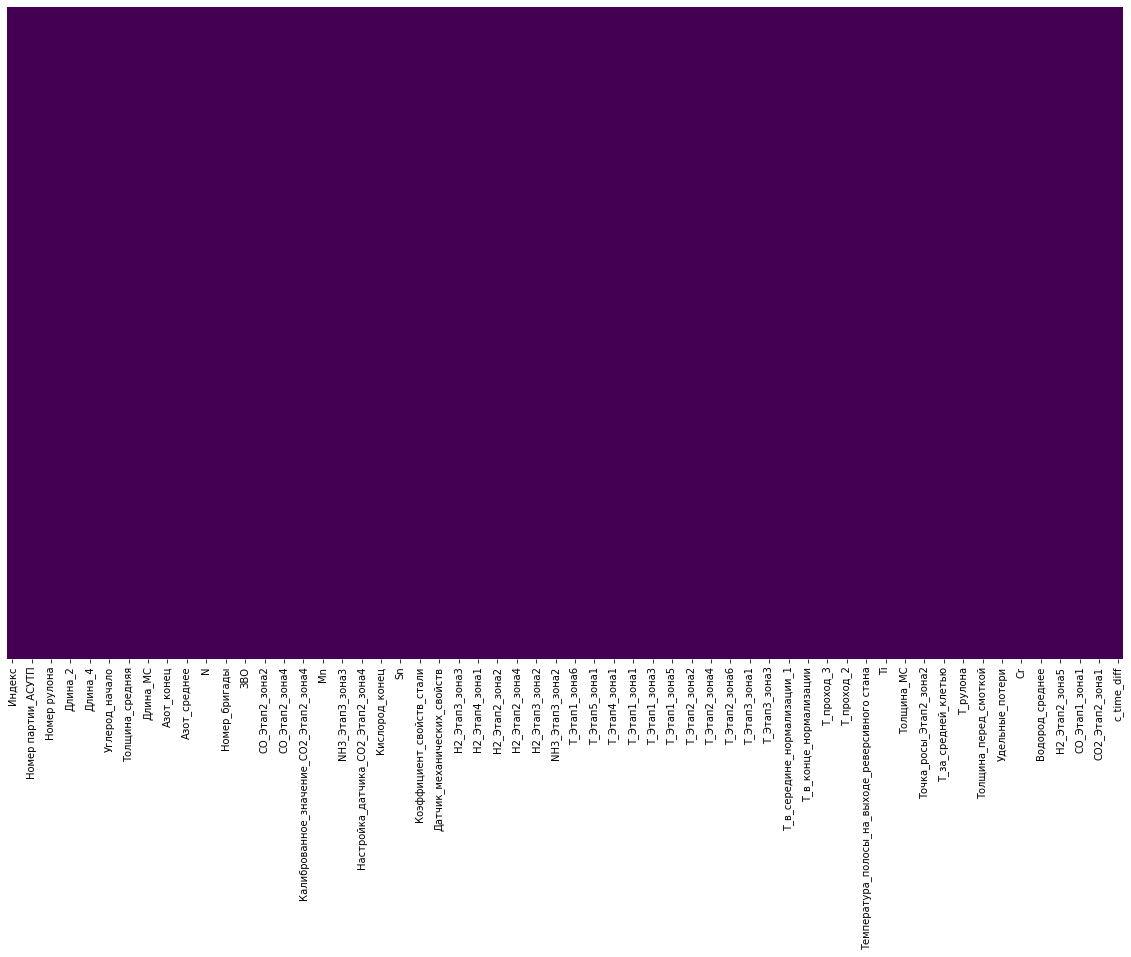

In [11]:
visual_check(data)

In [12]:
# Оставляем в колонке Толщина_перед_смоткой только числовые значения
import re
for i in range(len(data['Толщина_перед_смоткой'])):
  val = data.loc[i,'Толщина_перед_смоткой']
  if (type(val) == str):
    val = re.sub(' ','',val)
    val = re.sub('[а-яА-ЯёЁ]','',val)
    val = re.sub('[a-zA-Z]','',val)
    val = re.sub('_','',val)
    val = val.replace('.','')
    val = val.replace(',','.')
    val = float(val)
    data.loc[i,'Толщина_перед_смоткой'] = val

# Преобразуем во float
data['Толщина_перед_смоткой'] = data['Толщина_перед_смоткой'].astype(float)
data['Толщина_перед_смоткой']

0        2.300000
1        2.300000
2        2.300000
3        2.300000
4        2.300000
           ...   
12786    2.311269
12787    2.308452
12788    2.305635
12789    2.302817
12790    2.300000
Name: Толщина_перед_смоткой, Length: 12791, dtype: float64

In [13]:
# Удаляем колонки с общей информацией и свойствами на выходе
data = data.drop( (main_info + chem_end + magnetic_char), axis=1)
data

,Длина_1,Длина_2,Длина_3,Длина_4,Длина_5,Длина_Обезуглероживание,Длина_ГП,Длина_Н,N,Al,Номер_бригады,CO_Этап2_зона1,CO_Этап2_зона2,CO_Этап2_зона3,CO_Этап2_зона4,CO2_Этап1,Калиброванное_значение_CO2_Этап2_зона4,Si,Mn,Cu,NH3_Этап3_зона3,T_Этап3_зона4,Настройка_датчика_CO2_Этап2_зона4,Ni,Sn,S,Датчик_механических_свойств,H2_Этап3_зона3,Скорость_технологической_секции,H2_Этап4_зона1,H2_Этап2_зона1,H2_Этап2_зона2,H2_Этап2_зона3,H2_Этап2_зона4,H2_Этап3_зона1,H2_Этап3_зона2,NH3_Этап3_зона1,NH3_Этап3_зона2,CO_Этап2_зона5,T_Этап1_зона6,Т_Этап5_зона1,Т_Этап5_зона2,Т_Этап4_зона1,Т_Этап4_зона2,T_Этап1_зона1,T_Этап1_зона2,T_Этап1_зона3,T_Этап1_зона4,T_Этап1_зона5,T_Этап2_зона1,T_Этап2_зона2,T_Этап2_зона3,T_Этап2_зона4,T_Этап2_зона5,T_Этап2_зона6,T_Этап2_зона7,T_Этап3_зона1,T_Этап3_зона2,T_Этап3_зона3,T_в_начале_нормализации,T_в_середине_нормализации_1,T_в_середине_нормализации_2,T_в_конце_нормализации,T_проход_1,T_проход_3,T_проход_5,T_проход_2,T_проход_4,Температура_полосы_на_выходе_реверсивного стана,ШОС,Ti,Длина_Азотирование,Точка_росы_Этап4_зона1,Точка_росы_Этап2_зона2,Точка_росы_Этап2_зона3,T_за_средней_клетью,T_конца_проката,T_рулона,Тренд_температуры_перед_реверсивным_станом,Толщина_перед_смоткой,C,Удельные_потери,F,Cr,CO2_Этап2_зона5,H2_Этап2_зона5,Точка_росы_Этап1_зона1,CO_Этап1_зона1,H2_Этап1,CO2_Этап2_зона1,CO2_Этап2_зона3,c_time_diff
0,"23,28",2214,"55,6","5111,88","121,76","121,12","46,32","25,2","0,0083","0,028",1,"1,73","1,15","0,46","0,21","0,11","-0,02","3,315","0,14","0,01","0,1501156362",309,0,"0,01","0,003","0,005","35,80168","0,1020408163",68,"51,69","69,17","68,23","65,46","53,39",36,"18,70496","0,03","0,96","1,570693878",0,"747,84448","745,99","839,96","839,57552","930,18","929,64","909,09992","900,0412","868,47","839,90224","839,9","840,42208","839,81","839,19776",839.522240,"839,3256","770,44","769,47112","771,61576","1097,4032","1098,0032","1091,0952","902,1128","135,6911704","181,605608","199,7500384","178,91038","191,5273",100,Melubir 6736/LI,"0,002",3560,"-19,86","61,00448","59,75328","948,368","922,7870476","593,184381",364,2.300000,"0,055","1,072","0,024","0,11","1,22","69,7","63,68","1,6","69,75","0,1","0,06",2684
1,"25,22",2211,"60,23333333","5104,953333","131,9066667","131,2133333","47,68","27,3","0,0083","0,028",1,"1,73","1,15","0,46","0,21","0,11","0,8214709848","3,315","0,14","0,01","0,756901005",25,"0,8414709848","0,01","0,003","0,005","42,80209333","0,1020408163",68,"51,69","69,17","68,23","65,46","53,39",36,"14,9254","0,03","0,96","1,570502986",0,"747,88","745,9924267","839,9624267","839,5387867","930,1775733","929,64","909,02","900,1457733","868,47","839,9212133","839,9084933","840,2848533","839,81","839,1812133",839.524227,"839,35908","770,44","769,4884933","771,83092","1097,4368","1098,0368","1091,0448","902,2472","136,5621044","183,547782","200,2143333","179,18122","193,1751",100,Melubir 6736/LI,"0,002",3680,"-19,86","61,03514667","59,69029333","948,232","922,8129524","591,215619",364,2.300000,"0,055","1,087","0,024","0,11","1,22","70,8","63,68","1,6","69,75","0,1","0,06",2684
2,"27,16",2208,"64,86666667","5098,026667","142,0533333","141,3066667","49,04","29,4","0,0083","0,028",1,"1,73","1,15","0,46","0,21","0,11","0,8892974268","3,315","0,14","0,01","0,149549359",290,"0,9092974268","0,01","0,003","0,005","49,01098667","0,1020408163",68,"51,69","69,17","68,23","65,46","53,39",36,"9,393013333","0,03","0,96","1,570326623",0,"747,8826133","746,02568","839,98","839,56528","930,1495467","929,6334667","909,0213067","900,2704533","868,47","839,9365333","839,9713067","840,3330667","839,81","839,1965333",839.413920,"839,2865333","770,44","769,5565333","771,91392","1097,4704","1098,0704","1090,9944","902,3816","135,8443432","183,523596","203,1043077","179,2715","194,3307235",102,Melubir 6736/LI,"0,002",4052,"-19,86","60,99738667","59,61216","948,096","922,8388571","589,2468571",363,2.300000,"0,055","1,07","0,024","0,11","1,25","69,9","63,67869333","1,6","69,75","0,1","0,06",2684
3,"29,1",2205,"69,5","5091,1

In [14]:
# Смотрим сколько уникальных значений в колонках
unique_df = pd.DataFrame(columns=['column', 'nb_unique', 'dtype'])
for col in data.columns:
  if data[col].nunique()== 1:  # Удаляем колонки с 1 уникальным значением
    data = data.drop(col, axis=1)
  else:
    unique_df = unique_df.append([{'column': col, 'nb_unique': data[col].nunique(), 'dtype': data[col].dtype}])
unique_df.reset_index(inplace=True, drop=True)
unique_df.sort_values('nb_unique', ascending=True).head(20)

,column,nb_unique,dtype
66,Ti,2,object
23,S,2,object
22,Sn,2,object
18,Mn,2,object
78,F,2,object
79,Cr,2,object
9,Al,3,object
10,Номер_бригады,3,int64
76,C,4,object
8,N,4,object


In [15]:
# Выводим значения колонок, где уникальных значений не более 5
for col in unique_df[unique_df['nb_unique'] <= 5]['column'].values:
  print(col, data[col].unique())

N ['0,0083' '0,0069' '0,0077' '0,0075']
Al ['0,028' '0,03' '0,029']
Номер_бригады [1 3 2]
Si ['3,315' '3,333' '3,331' '3,255' '3,32']
Mn ['0,14' '0,16']
Sn ['0,003' '0,002']
S ['0,005' '0,006']
ШОС ['Melubir 6736/LI' 'Melubir 6733/LI' 'Melubir 6739/LI' 'Melubir 6738/LI'
 'Melubir 6731/LI']
Ti ['0,002' '0,003']
C ['0,055' '0,054' '0,052' '0,056']
F ['0,024' '0,025']
Cr ['0,11' '0,12']
c_time_diff [2684 2630 2743 2716 2755]


In [16]:
#  Определяем колонки, в которых категориальные данные
categorical_columns = unique_df[unique_df['nb_unique'] <= 2]['column'].to_list()
categorical_columns = categorical_columns + ['Номер_бригады', 'ШОС']
data[categorical_columns] = data[categorical_columns].astype('category')

In [17]:
# Делаем OHE для колонок с категориями
ohe_columns = []  # Названия ohe колонок
def encode_and_bind(original_dataframe, info_df, feature_to_encode):
  threatment_stage = info_df.loc[info_df['Название параметра'] == feature_to_encode]['Этап обработки'].values[0]
  dummies = pd.get_dummies(original_dataframe[[feature_to_encode]])
  for dummie in dummies.columns:
    info_df = info_df.append([{"Название параметра": dummie, 'Этап обработки': threatment_stage}])
  ohe_columns.extend(dummies.columns)
  original_dataframe = pd.concat([original_dataframe, dummies], axis=1)
  original_dataframe = original_dataframe.drop([feature_to_encode], axis=1)
  return original_dataframe, info_df

for feature in categorical_columns:
  data, info = encode_and_bind(data, info, feature)

In [19]:
ohe_columns

['Mn_0,14',
 'Mn_0,16',
 'Sn_0,002',
 'Sn_0,003',
 'S_0,005',
 'S_0,006',
 'Ti_0,002',
 'Ti_0,003',
 'F_0,024',
 'F_0,025',
 'Cr_0,11',
 'Cr_0,12',
 'Номер_бригады_1',
 'Номер_бригады_2',
 'Номер_бригады_3',
 'ШОС_Melubir 6731/LI',
 'ШОС_Melubir 6733/LI',
 'ШОС_Melubir 6736/LI',
 'ШОС_Melubir 6738/LI',
 'ШОС_Melubir 6739/LI']

In [18]:
# преобразуем 'oject' во float
print(data.shape)  # Проверяем размер датасета до
for feature in data.select_dtypes('object').columns:
  try:
    data[feature] = data[feature].astype('float')
  except:
    data[feature] = [str(val).replace( ',','.') for val in data[feature].values]
    data[feature] = data[feature].astype('float')

print(data.shape)  # И после


(12791, 100)
(12791, 100)


In [20]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12791 entries, 0 to 12790
Data columns (total 100 columns):
 #   Column                                           Non-Null Count  Dtype  
---  ------                                           --------------  -----  
 0   Длина_1                                          12791 non-null  float64
 1   Длина_2                                          12791 non-null  float64
 2   Длина_3                                          12791 non-null  float64
 3   Длина_4                                          12791 non-null  float64
 4   Длина_5                                          12791 non-null  float64
 5   Длина_Обезуглероживание                          12791 non-null  float64
 6   Длина_ГП                                         12791 non-null  float64
 7   Длина_Н                                          12791 non-null  float64
 8   N                                                12791 non-null  float64
 9   Al                         

In [21]:
data

,Длина_1,Длина_2,Длина_3,Длина_4,Длина_5,Длина_Обезуглероживание,Длина_ГП,Длина_Н,N,Al,CO_Этап2_зона1,CO_Этап2_зона2,CO_Этап2_зона3,CO_Этап2_зона4,CO2_Этап1,Калиброванное_значение_CO2_Этап2_зона4,Si,NH3_Этап3_зона3,T_Этап3_зона4,Настройка_датчика_CO2_Этап2_зона4,Датчик_механических_свойств,Скорость_технологической_секции,H2_Этап4_зона1,H2_Этап2_зона1,H2_Этап2_зона2,H2_Этап2_зона3,H2_Этап2_зона4,H2_Этап3_зона1,H2_Этап3_зона2,NH3_Этап3_зона1,NH3_Этап3_зона2,CO_Этап2_зона5,Т_Этап5_зона1,Т_Этап5_зона2,Т_Этап4_зона1,Т_Этап4_зона2,T_Этап1_зона1,T_Этап1_зона2,T_Этап1_зона3,T_Этап1_зона4,T_Этап1_зона5,T_Этап2_зона1,T_Этап2_зона2,T_Этап2_зона3,T_Этап2_зона4,T_Этап2_зона5,T_Этап2_зона6,T_Этап2_зона7,T_Этап3_зона1,T_Этап3_зона2,T_Этап3_зона3,T_в_начале_нормализации,T_в_середине_нормализации_1,T_в_середине_нормализации_2,T_в_конце_нормализации,T_проход_1,T_проход_3,T_проход_5,T_проход_2,T_проход_4,Температура_полосы_на_выходе_реверсивного стана,Длина_Азотирование,Точка_росы_Этап4_зона1,Точка_росы_Этап2_зона2,Точка_росы_Этап2_зона3,T_за_средней_клетью,T_конца_проката,T_рулона,Тренд_температуры_перед_реверсивным_станом,Толщина_перед_смоткой,C,Удельные_потери,CO2_Этап2_зона5,H2_Этап2_зона5,Точка_росы_Этап1_зона1,CO_Этап1_зона1,H2_Этап1,CO2_Этап2_зона1,CO2_Этап2_зона3,c_time_diff,"Mn_0,14","Mn_0,16","Sn_0,002","Sn_0,003","S_0,005","S_0,006","Ti_0,002","Ti_0,003","F_0,024","F_0,025","Cr_0,11","Cr_0,12",Номер_бригады_1,Номер_бригады_2,Номер_бригады_3,ШОС_Melubir 6731/LI,ШОС_Melubir 6733/LI,ШОС_Melubir 6736/LI,ШОС_Melubir 6738/LI,ШОС_Melubir 6739/LI
0,23.280000,2214.000000,55.600000,5111.880000,121.760000,121.120000,46.320000,25.200000,0.0083,0.028,1.73,1.15,0.46,0.21,0.11,-0.020000,3.315,0.150116,309,0.000000,35.801680,68.0,51.69,69.17,68.23,65.46,53.39,36.00,18.704960,0.03,0.96,1.570694,747.844480,745.990000,839.960000,839.575520,930.180000,929.640000,909.099920,900.041200,868.47,839.902240,839.900000,840.422080,839.810000,839.197760,839.522240,839.325600,770.440000,769.471120,771.615760,1097.403200,1098.003200,1091.095200,902.112800,135.691170,181.605608,199.750038,178.910380,191.527300,100,3560,-19.860000,61.004480,59.753280,948.368000,922.787048,593.184381,364,2.300000,0.055,1.072,1.22,69.7,63.680000,1.60,69.75,0.10,0.06,2684,1,0,0,1,1,0,1,0,1,0,1,0,1,0,0,0,0,1,0,0
1,25.220000,2211.000000,60.233333,5104.953333,131.906667,131.213333,47.680000,27.300000,0.0083,0.028,1.73,1.15,0.46,0.21,0.11,0.821471,3.315,0.756901,25,0.841471,42.802093,68.0,51.69,69.17,68.23,65.46,53.39,36.00,14.925400,0.03,0.96,1.570503,747.880000,745.992427,839.962427,839.538787,930.177573,929.640000,909.020000,900.145773,868.47,839.921213,839.908493,840.284853,839.810000,839.181213,839.524227,839.359080,770.440000,769.488493,771.830920,1097.436800,1098.036800,1091.044800,902.247200,136.562104,183.547782,200.214333,179.181220,193.175100,100,3680,-19.860000,61.035147,59.690293,948.232000,922.812952,591.215619,364,2.300000,0.055,1.087,1.22,70.8,63.680000,1.60,69.75,0.10,0.06,2684,1,0,0,1,1,0,1,0,1,0,1,0,1,0,0,0,0,1,0,0
2,27.160000,2208.000000,64.866667,5098.026667,142.053333,141.306667,49.040000,29.400000,0.0083,0.028,1.73,1.15,0.46,0.21,0.11,0.889297,3.315,0.149549,290,0.909297,49.010987,68.0,51.69,69.17,68.23,65.46,53.39,36.00,9.393013,0.03,0.96,1.570327,747.882613,746.025680,839.980000,839.565280,930.149547,929.633467,909.021307,900.270453,868.47,839.936533,839.971307,840.333067,839.810000,839.196533,839.413920,839.286533,770.440000,769.556533,771.913920,1097.470400,1098.070400,1090.994400,902.381600,135.844343,183.523596,203.104308,179.271500,194.330724,102,4052,-19.860000,60.997387,59.612160,948.096000,922.838857,589.246857,363,2.300000,0.055,1.070,1.25,69.9,63.678693,1.60,69.75,0.10,0.06,2684,1,0,0,1,1,0,1,0,1,0,1,0,1,0,0,0,0,1,0,0
3,29.100000,2205.000000,69.500000,5091.100000,152.200000,151.400000,50.400000,31.500000,0.0083,0.028,1.73,1.15,0.46,0.21,0.11,0.121120,3.315,0.994824,231,0.141120,47.764000,68.0,51.69,69.17,68.23,65.46,53.39,36.00,19.393900,0.03,0.96,1.570711

In [22]:
data_train, data_val = train_test_split(data, shuffle=True)
data_val

,Длина_1,Длина_2,Длина_3,Длина_4,Длина_5,Длина_Обезуглероживание,Длина_ГП,Длина_Н,N,Al,CO_Этап2_зона1,CO_Этап2_зона2,CO_Этап2_зона3,CO_Этап2_зона4,CO2_Этап1,Калиброванное_значение_CO2_Этап2_зона4,Si,NH3_Этап3_зона3,T_Этап3_зона4,Настройка_датчика_CO2_Этап2_зона4,Датчик_механических_свойств,Скорость_технологической_секции,H2_Этап4_зона1,H2_Этап2_зона1,H2_Этап2_зона2,H2_Этап2_зона3,H2_Этап2_зона4,H2_Этап3_зона1,H2_Этап3_зона2,NH3_Этап3_зона1,NH3_Этап3_зона2,CO_Этап2_зона5,Т_Этап5_зона1,Т_Этап5_зона2,Т_Этап4_зона1,Т_Этап4_зона2,T_Этап1_зона1,T_Этап1_зона2,T_Этап1_зона3,T_Этап1_зона4,T_Этап1_зона5,T_Этап2_зона1,T_Этап2_зона2,T_Этап2_зона3,T_Этап2_зона4,T_Этап2_зона5,T_Этап2_зона6,T_Этап2_зона7,T_Этап3_зона1,T_Этап3_зона2,T_Этап3_зона3,T_в_начале_нормализации,T_в_середине_нормализации_1,T_в_середине_нормализации_2,T_в_конце_нормализации,T_проход_1,T_проход_3,T_проход_5,T_проход_2,T_проход_4,Температура_полосы_на_выходе_реверсивного стана,Длина_Азотирование,Точка_росы_Этап4_зона1,Точка_росы_Этап2_зона2,Точка_росы_Этап2_зона3,T_за_средней_клетью,T_конца_проката,T_рулона,Тренд_температуры_перед_реверсивным_станом,Толщина_перед_смоткой,C,Удельные_потери,CO2_Этап2_зона5,H2_Этап2_зона5,Точка_росы_Этап1_зона1,CO_Этап1_зона1,H2_Этап1,CO2_Этап2_зона1,CO2_Этап2_зона3,c_time_diff,"Mn_0,14","Mn_0,16","Sn_0,002","Sn_0,003","S_0,005","S_0,006","Ti_0,002","Ti_0,003","F_0,024","F_0,025","Cr_0,11","Cr_0,12",Номер_бригады_1,Номер_бригады_2,Номер_бригады_3,ШОС_Melubir 6731/LI,ШОС_Melubir 6733/LI,ШОС_Melubir 6736/LI,ШОС_Melubir 6738/LI,ШОС_Melubir 6739/LI
1687,441.343750,1589.854167,1061.822917,3667.552083,2341.145833,2341.145833,338.125000,415.364583,0.0083,0.028,1.68,1.13,0.45,0.21,0.10,0.015248,3.315,0.044634,589,0.035248,47.048854,68.0,50.280000,68.93,67.84,64.930000,53.520000,34.86,19.833437,0.03,0.88,1.570622,747.933125,746.015208,841.995417,842.403750,930.449375,929.310000,908.670000,899.080000,868.152292,840.802812,840.236875,840.226875,839.837708,839.960000,839.923125,840.186563,770.438854,770.570312,769.445938,1098.500000,1098.615625,1091.492708,904.551042,131.311156,230.532272,195.627300,202.249900,219.926100,98,1502,-19.858854,60.747708,59.580000,961.000000,926.187500,566.468750,349,2.281875,0.055,1.058,2.60,68.1,63.527708,1.54,69.59,0.10,0.05,2684,1,0,0,1,1,0,1,0,1,0,1,0,0,0,1,0,0,1,0,0
11,44.620000,2181.000000,106.566667,5035.686667,233.373333,232.146667,61.280000,48.300000,0.0083,0.028,1.73,1.15,0.46,0.21,0.10,-1.019990,3.315,-0.868548,926,-0.999990,46.807720,68.0,50.890000,69.17,68.23,65.460000,53.390000,36.00,20.418947,0.03,0.96,1.568717,748.130627,746.638587,840.246440,839.934293,929.210000,929.287800,908.980000,900.406440,868.470000,840.544293,840.278533,840.447853,839.794293,839.072147,839.232040,839.271413,770.750000,769.864293,771.949840,1097.772800,1098.372800,1090.540800,903.591200,140.863887,205.977462,217.078300,180.426380,202.947600,109,526,-19.860000,60.885707,59.707853,948.000000,921.132000,577.004000,359,2.298720,0.055,1.054,1.04,68.8,63.750000,1.58,69.70,0.10,0.06,2684,1,0,0,1,1,0,1,0,1,0,1,0,1,0,0,0,0,1,0,0
6469,30.061644,2196.910959,71.157534,5063.767123,152.157534,151.232877,50.958904,26.712329,0.0077,0.028,1.67,1.11,0.44,0.22,0.10,-0.454599,3.331,0.989279,904,-0.444599,61.562192,68.0,49.390000,69.36,68.58,66.040000,55.130000,34.29,22.236986,0.03,0.94,1.570626,742.150000,744.568767,839.036301,838.760000,928.911233,926.450000,909.620000,896.707534,867.596301,839.337534,838.922329,839.463836,839.157397,838.694932,838.883836,839.020000,770.440000,770.326027,770.662329,1100.058904,1100.124658,1093.752055,908.721918,153.421135,202.976714,203.701800,201.884695,193.129374,102,572,-17.317534,60.476301,58.692603,943.095890,922.756360,583.676125,369,2.300000,0.054,0.972,1.14,70.3,63.641233,1.55,69.94,0.10,0.05,2743,1,0,0,1,0,1,0,1,1,0,1,0,0,1,0,0,0,0,0,1
4784,740.833333,1071.483740,1773.353659,2484.004065,3879.695122,3856.463415,556.585366,619.512195,0.0069,0.030,1.62,1.07,0.42,0.18,0.09,0.571687,3.333,-0.279560,406,0.601687,63

In [23]:
X = data_train.loc[:, data_train.columns != y_label]
y = data_train[y_label]

X_val = data_val.loc[:, data_val.columns != y_label]
y_val = data_val[y_label]

In [24]:
print(X.shape, y.shape)
print(y[y < Y_LIMIT].count())  # Сколько хороших результатов
print(X_val.shape, y_val.shape)
print(y_val[y_val < Y_LIMIT].count())  # Сколько хороших результатов

(9593, 99) (9593,)
4682
(3198, 99) (3198,)
1558


In [25]:
def scale_column(df, column_name, train=True):
  scaler_filename=f"/content/drive/MyDrive/Colab Notebooks/IBS/scalers/scaler_{column_name}.save"
  if train:
    scaler = StandardScaler()
    df.loc[:,column_name] = scaler.fit_transform(df.loc[:,column_name].values.reshape(-1,1))
    joblib.dump(scaler, scaler_filename)
  else:
    scaler = joblib.load(scaler_filename)
    df.loc[:,column_name] = scaler.transform(df.loc[:,column_name].values.reshape(-1,1))
  return df

In [26]:
# Нормализуем данные по колонкам
pd.options.mode.chained_assignment = None
if not os.path.exists("/content/drive/MyDrive/Colab Notebooks/IBS/scalers/"):
  os.makedirs("/content/drive/MyDrive/Colab Notebooks/IBS/scalers/")

for c in X.columns:
  if c not in ohe_columns:  # Кроме колонок с OHE
    X = scale_column(X, c)

for c in X_val.columns:
  if c not in ohe_columns:  # Кроме колонок с OHE
    X_val = scale_column(X_val, c, train=False)

In [27]:
X.describe()

,Длина_1,Длина_2,Длина_3,Длина_4,Длина_5,Длина_Обезуглероживание,Длина_ГП,Длина_Н,N,Al,CO_Этап2_зона1,CO_Этап2_зона2,CO_Этап2_зона3,CO_Этап2_зона4,CO2_Этап1,Калиброванное_значение_CO2_Этап2_зона4,Si,NH3_Этап3_зона3,T_Этап3_зона4,Настройка_датчика_CO2_Этап2_зона4,Датчик_механических_свойств,Скорость_технологической_секции,H2_Этап4_зона1,H2_Этап2_зона1,H2_Этап2_зона2,H2_Этап2_зона3,H2_Этап2_зона4,H2_Этап3_зона1,H2_Этап3_зона2,NH3_Этап3_зона1,NH3_Этап3_зона2,CO_Этап2_зона5,Т_Этап5_зона1,Т_Этап5_зона2,Т_Этап4_зона1,Т_Этап4_зона2,T_Этап1_зона1,T_Этап1_зона2,T_Этап1_зона3,T_Этап1_зона4,T_Этап1_зона5,T_Этап2_зона1,T_Этап2_зона2,T_Этап2_зона3,T_Этап2_зона4,T_Этап2_зона5,T_Этап2_зона6,T_Этап2_зона7,T_Этап3_зона1,T_Этап3_зона2,T_Этап3_зона3,T_в_начале_нормализации,T_в_середине_нормализации_1,T_в_середине_нормализации_2,T_в_конце_нормализации,T_проход_1,T_проход_3,T_проход_5,T_проход_2,T_проход_4,Температура_полосы_на_выходе_реверсивного стана,Длина_Азотирование,Точка_росы_Этап4_зона1,Точка_росы_Этап2_зона2,Точка_росы_Этап2_зона3,T_за_средней_клетью,T_конца_проката,T_рулона,Тренд_температуры_перед_реверсивным_станом,Толщина_перед_смоткой,C,CO2_Этап2_зона5,H2_Этап2_зона5,Точка_росы_Этап1_зона1,CO_Этап1_зона1,H2_Этап1,CO2_Этап2_зона1,CO2_Этап2_зона3,c_time_diff,"Mn_0,14","Mn_0,16","Sn_0,002","Sn_0,003","S_0,005","S_0,006","Ti_0,002","Ti_0,003","F_0,024","F_0,025","Cr_0,11","Cr_0,12",Номер_бригады_1,Номер_бригады_2,Номер_бригады_3,ШОС_Melubir 6731/LI,ШОС_Melubir 6733/LI,ШОС_Melubir 6736/LI,ШОС_Melubir 6738/LI,ШОС_Melubir 6739/LI
count,9.593000e+03,9.593000e+03,9.593000e+03,9.593000e+03,9.593000e+03,9.593000e+03,9.593000e+03,9.593000e+03,9.593000e+03,9.593000e+03,9.593000e+03,9.593000e+03,9.593000e+03,9.593000e+03,9.593000e+03,9.593000e+03,9.593000e+03,9.593000e+03,9.593000e+03,9.593000e+03,9.593000e+03,9.593000e+03,9.593000e+03,9.593000e+03,9.593000e+03,9.593000e+03,9.593000e+03,9.593000e+03,9.593000e+03,9.593000e+03,9.593000e+03,9.593000e+03,9.593000e+03,9.593000e+03,9.593000e+03,9.593000e+03,9.593000e+03,9.593000e+03,9.593000e+03,9.593000e+03,9.593000e+03,9.593000e+03,9.593000e+03,9.593000e+03,9.593000e+03,9.593000e+03,9.593000e+03,9.593000e+03,9.593000e+03,9.593000e+03,9.593000e+03,9.593000e+03,9.593000e+03,9.593000e+03,9.593000e+03,9.593000e+03,9.593000e+03,9.593000e+03,9.593000e+03,9.593000e+03,9.593000e+03,9.593000e+03,9.593000e+03,9.593000e+03,9.593000e+03,9.593000e+03,9.593000e+03,9.593000e+03,9.593000e+03,9.593000e+03,9.593000e+03,9.593000e+03,9.593000e+03,9.593000e+03,9.593000e+03,9.593000e+03,9.593000e+03,9.593000e+03,9.593000e+03,9593.000000,9593.000000,9593.000000,9593.000000,9593.000000,9593.000000,9593.000000,9593.000000,9593.000000,9593.000000,9593.000000,9593.000000,9593.000000,9593.000000,9593.000000,9593.000000,9593.000000,9593.000000,9593.000000,9593.000000
mean,2.620187e-16,5.740338e-17,9.132461e-17,1.443996e-16,1.086729e-16,-3.026639e-16,-2.838921e-16,-7.899330e-17,-2.326781e-15,-1.539989e-14,-1.180797e-15,7.240927e-16,-1.186213e-15,-2.268938e-16,-1.130974e-15,-4.437189e-17,-8.725661e-15,-2.472049e-17,-6.462510e-17,-6.990250e-18,-9.224584e-16,-1.581729e-14,3.568610e-15,3.208711e-14,-2.264138e-14,4.905686e-15,-1.527439e-16,5.823735e-15,-2.514870e-16,-1.757843e-15,1.070492e-15,-7.175899e-15,-1.949855e-14,-8.685173e-14,1.475377e-13,-7.005795e-14,-5.795233e-14,7.598078e-14,-1.455329e-13,-7.379445e-16,-1.628271e-14,1.218839e-13,8.136999e-14,3.713619e-13,-8.096874e-14,1.476469e-13,-7.804788e-14,-1.034854e-13,1.865968e-13,-1.342518e-13,-1.756705e-13,-5.220357e-14,5.840323e-14,4.749710e-14,-4.956369e-14,-7.036196e-16,-1.146361e-16,-9.533706e-16,-1.641227e-15,1.476355e-15,1.788185e-16,9.096005e-17,5.813250e-16,-7.075927e-15,-6.662079e-15,4.709600e-15,-6.763599e-15,1.310903e-15,-2.250421e-15,3.618398e-14,-1.718778e-14,5.117002e-16,1.363390e-14,9.791917e-15,3.639160e-15,7.117064e-16,3.446778e-16,-2.858781e-15,2.742909e-15,0.841551,0.158449,0.323569,0.676431,0.619202,0.380798,0.784322,0.215678,0.555301,0.444699,0.390180,0.609820,0

In [28]:
X_val.describe()

,Длина_1,Длина_2,Длина_3,Длина_4,Длина_5,Длина_Обезуглероживание,Длина_ГП,Длина_Н,N,Al,CO_Этап2_зона1,CO_Этап2_зона2,CO_Этап2_зона3,CO_Этап2_зона4,CO2_Этап1,Калиброванное_значение_CO2_Этап2_зона4,Si,NH3_Этап3_зона3,T_Этап3_зона4,Настройка_датчика_CO2_Этап2_зона4,Датчик_механических_свойств,Скорость_технологической_секции,H2_Этап4_зона1,H2_Этап2_зона1,H2_Этап2_зона2,H2_Этап2_зона3,H2_Этап2_зона4,H2_Этап3_зона1,H2_Этап3_зона2,NH3_Этап3_зона1,NH3_Этап3_зона2,CO_Этап2_зона5,Т_Этап5_зона1,Т_Этап5_зона2,Т_Этап4_зона1,Т_Этап4_зона2,T_Этап1_зона1,T_Этап1_зона2,T_Этап1_зона3,T_Этап1_зона4,T_Этап1_зона5,T_Этап2_зона1,T_Этап2_зона2,T_Этап2_зона3,T_Этап2_зона4,T_Этап2_зона5,T_Этап2_зона6,T_Этап2_зона7,T_Этап3_зона1,T_Этап3_зона2,T_Этап3_зона3,T_в_начале_нормализации,T_в_середине_нормализации_1,T_в_середине_нормализации_2,T_в_конце_нормализации,T_проход_1,T_проход_3,T_проход_5,T_проход_2,T_проход_4,Температура_полосы_на_выходе_реверсивного стана,Длина_Азотирование,Точка_росы_Этап4_зона1,Точка_росы_Этап2_зона2,Точка_росы_Этап2_зона3,T_за_средней_клетью,T_конца_проката,T_рулона,Тренд_температуры_перед_реверсивным_станом,Толщина_перед_смоткой,C,CO2_Этап2_зона5,H2_Этап2_зона5,Точка_росы_Этап1_зона1,CO_Этап1_зона1,H2_Этап1,CO2_Этап2_зона1,CO2_Этап2_зона3,c_time_diff,"Mn_0,14","Mn_0,16","Sn_0,002","Sn_0,003","S_0,005","S_0,006","Ti_0,002","Ti_0,003","F_0,024","F_0,025","Cr_0,11","Cr_0,12",Номер_бригады_1,Номер_бригады_2,Номер_бригады_3,ШОС_Melubir 6731/LI,ШОС_Melubir 6733/LI,ШОС_Melubir 6736/LI,ШОС_Melubir 6738/LI,ШОС_Melubir 6739/LI
count,3198.000000,3198.000000,3198.000000,3198.000000,3198.000000,3198.000000,3198.000000,3198.000000,3198.000000,3198.000000,3198.000000,3198.000000,3198.000000,3198.000000,3198.000000,3198.000000,3198.000000,3198.000000,3198.000000,3198.000000,3198.000000,3198.000000,3198.000000,3198.000000,3198.000000,3198.000000,3198.000000,3198.000000,3198.000000,3198.000000,3198.000000,3198.000000,3198.000000,3198.000000,3198.000000,3198.000000,3198.000000,3198.000000,3198.000000,3198.000000,3198.000000,3198.000000,3198.000000,3198.000000,3198.000000,3198.000000,3198.000000,3198.000000,3198.000000,3198.000000,3198.000000,3198.000000,3198.000000,3198.000000,3198.000000,3198.000000,3198.000000,3198.000000,3198.000000,3198.000000,3198.000000,3198.000000,3198.000000,3198.000000,3198.000000,3198.000000,3198.000000,3198.000000,3198.000000,3198.000000,3198.000000,3198.000000,3198.000000,3198.000000,3198.000000,3198.000000,3198.000000,3198.000000,3198.000000,3198.000000,3198.000000,3198.000000,3198.000000,3198.000000,3198.000000,3198.000000,3198.000000,3198.000000,3198.000000,3198.000000,3198.000000,3198.000000,3198.000000,3198.000000,3198.000000,3198.000000,3198.000000,3198.000000,3198.000000
mean,-0.009407,0.008978,-0.009949,0.009364,-0.010681,-0.010987,-0.009725,-0.000656,0.002821,0.004336,0.017393,0.015675,0.011350,0.014511,0.014214,-0.015626,0.002211,0.010405,0.011053,-0.015710,-0.009350,-0.038167,-0.001913,0.004736,0.010364,0.012768,-0.003126,-0.011163,-0.006621,0.001519,0.002363,-0.033787,0.010765,0.007459,0.011824,0.011180,0.004519,-0.005797,-0.017321,-0.021970,-0.023738,-0.003329,-0.007889,0.009030,0.011687,0.009426,0.025554,0.025382,0.002636,0.009837,0.017793,-0.008309,-0.013089,-0.009822,-0.011846,0.001823,0.000476,-0.005013,-0.007414,-0.013882,-0.004071,0.026733,0.012341,-0.002241,-0.002808,-0.008224,0.011367,0.031631,0.012590,-0.005959,0.009074,0.030052,0.006112,0.010317,0.030530,0.021926,0.016121,0.020232,0.014279,0.834584,0.165416,0.328956,0.671044,0.620388,0.379612,0.783927,0.216073,0.552533,0.447467,0.388993,0.611007,0.421513,0.242339,0.336148,0.165416,0.282051,0.172921,0.163540,0.216073
std,1.008439,1.008695,1.007931,1.009303,1.006738,1.006422,1.007894,1.021482,0.994452,1.000838,1.001003,0.989318,0.970611,0.971081,0.977562,0.995622,0.995644,1.008394,0.989243,0.995504,1.015366,1.101731,0.993274,0.956623,0.990063,0.993130,1.058004,1.008709,0.995364,0.937758,1.003214,2.057084,1.000782,0.991173,1.015218,1.019077,0.986635

# 2. Таблица признаков

In [29]:
!pip install boruta
from boruta import BorutaPy
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

     |████████████████████████████████| 61kB 2.4MB/s 


In [31]:
forest = RandomForestRegressor(n_jobs=-1, max_depth=5).fit(np.array(X), np.array(y))
boruta = BorutaPy(
   estimator = forest, 
   n_estimators = 'auto',
   max_iter = 10 # number of trials to perform
)
### fit Boruta (it accepts np.array, not pd.DataFrame)
boruta.fit(np.array(X), np.array(y))
### print results
green_area = X.columns[boruta.support_].to_list()
blue_area = X.columns[boruta.support_weak_].to_list()
print('features in the green area:', green_area)
print('features in the blue area:', blue_area)

features in the green area: ['Длина_1', 'Длина_2', 'Длина_3', 'Длина_4', 'Длина_Н', 'N', 'Al', 'CO_Этап2_зона1', 'CO_Этап2_зона2', 'CO_Этап2_зона3', 'CO_Этап2_зона4', 'CO2_Этап1', 'Si', 'H2_Этап4_зона1', 'H2_Этап2_зона1', 'H2_Этап2_зона2', 'H2_Этап2_зона3', 'H2_Этап2_зона4', 'H2_Этап3_зона1', 'NH3_Этап3_зона2', 'Т_Этап4_зона2', 'T_Этап1_зона1', 'T_Этап1_зона2', 'T_Этап1_зона3', 'T_Этап1_зона4', 'T_Этап1_зона5', 'T_Этап2_зона1', 'T_Этап3_зона2', 'T_в_середине_нормализации_1', 'T_проход_5', 'T_проход_2', 'T_проход_4', 'Температура_полосы_на_выходе_реверсивного стана', 'Точка_росы_Этап2_зона2', 'Точка_росы_Этап2_зона3', 'T_конца_проката', 'C', 'Точка_росы_Этап1_зона1', 'CO_Этап1_зона1', 'H2_Этап1', 'CO2_Этап2_зона1', 'c_time_diff', 'Mn_0,14', 'Mn_0,16', 'F_0,024', 'F_0,025', 'Номер_бригады_2', 'Номер_бригады_3', 'ШОС_Melubir 6731/LI', 'ШОС_Melubir 6733/LI']
features in the blue area: ['Длина_5', 'Длина_Обезуглероживание', 'Длина_ГП', 'Т_Этап4_зона1', 'T_Этап2_зона2', 'T_Этап3_зона3', 'T_в

In [32]:
X_filter = boruta.transform(np.array(X))
print(X_filter.shape)
X_val_filter = boruta.transform(X_val.values)
print(X_val_filter.shape)

(9593, 50)
(3198, 50)


In [37]:
forest = RandomForestRegressor(n_jobs=-1, max_depth=5).fit(np.array(X_filter), np.array(y))
importance = forest.feature_importances_
forest_importances = pd.DataFrame(green_area, columns=['Название_признака'])
forest_importances['Важность_признака'] = importance
forest_importances = forest_importances.join(info.set_index('Название параметра'), on='Название_признака' ).drop('Описание', axis=1)
forest_importances = forest_importances.sort_values('Важность_признака', ascending=False)
forest_importances.reset_index(inplace=True, drop=True)
forest_importances

,Название_признака,Важность_признака,Этап обработки
0,CO_Этап2_зона3,0.266355,Обезуглероживание
1,ШОС_Melubir 6733/LI,0.209317,Химия плавки
2,Si,0.159052,Химия плавки
3,T_Этап1_зона5,0.072509,Обезуглероживание
4,H2_Этап2_зона4,0.042465,Обезуглероживание
5,Точка_росы_Этап2_зона3,0.038519,Обезуглероживание
6,c_time_diff,0.036808,NaN
7,T_проход_5,0.026433,Холодный прокат
8,N,0.016685,Химия плавки
9,H2_Этап4_зона1,0.013269,Обезуглероживание


# 3. Модели

In [81]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LassoCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import RidgeCV

In [41]:
def mae(X, y, model):
  pred = model.predict(X)
  pred = pred.flatten()
  delta = pred - np.array(y)
  absDelta = abs(delta)
  mae = sum(absDelta) / len(absDelta)
  return mae

In [86]:
def result_model(model, X, y):
  print(model.score(X, np.array(y)))
  print('mae:', round(mae(X, np.array(y), model),3))
  print('mean_val:', np.mean(np.array(y)))
  print('% error:', round(mae(X, np.array(y), model) /  np.mean(np.array(y)), 3) * 100)

In [95]:
# GradientBoostingRegressor
gbr = GradientBoostingRegressor(learning_rate=1, max_depth=3, random_state=0, loss='ls', n_estimators=500).fit(X_filter, np.array(y))
print(cross_val_score(gbr, X, np.array(y), cv=5, n_jobs=-1))
result_model(gbr, X_val_filter, np.array(y_val))

0.9447362171580186
[0.86609479 0.90428762 0.86242943 0.90917041 0.88864148]
mae: 0.031
mean_val: 1.2104984365228268
% error: 2.6


In [88]:
# RandomForestRegressor
forest = RandomForestRegressor(n_jobs=-1, n_estimators=50).fit(X_filter, np.array(y))
print(cross_val_score(forest, X, np.array(y), cv=5, n_jobs=-1))
result_model(forest, X_val_filter, np.array(y_val))

0.9699475769896445
[0.92289049 0.95691554 0.9204934  0.96679186 0.9676276 ]
mae: 0.016
mean_val: 1.2104984365228268
% error: 1.3


In [122]:
model_params = {
    'forest': {
        'model': RandomForestRegressor(),
        'params' : {
            'n_estimators': [10, 20, 50, 100, 150, 500, 750],
            'max_depth': [5, 10, 15, 20, None]
        }
    },
    'gbr' : {
        'model': GradientBoostingRegressor(random_state=0, loss='ls'),
        'params' : {
            'n_estimators': [50, 100, 250, 500, 750],
            'learning_rate': [0.5, 0.75, 1, 1.25, 1.5],
            'max_depth': [1, 3, 5, 10]
        }
    },
}

In [ ]:
scores = []

for model_name, mp in tqdm(model_params.items()):
    clf =  GridSearchCV(mp['model'], mp['params'], return_train_score=False, verbose=1, n_jobs=-1, cv=2)
    clf.fit(X_filter, y)
    scores.append({
        'model': model_name,
        'best_score': clf.best_score_,
        'best_params': clf.best_params_
    })
    
model_search = pd.DataFrame(scores,columns=['model','best_score','best_params'])
model_search

In [137]:
# Делаем stacking
forest = RandomForestRegressor(n_jobs=-1, n_estimators=50)
gbr = GradientBoostingRegressor(learning_rate=1, max_depth=3, random_state=0, loss='ls', n_estimators=500)

estimators = [('Forest', forest),
              ('Gbr', gbr),
              ]

stacking_regressor = StackingRegressor(
    estimators=estimators, final_estimator=forest)

for iterclf in [forest, gbr, stacking_regressor]:
  scores = cross_val_score(iterclf, X_filter, y, cv=5, n_jobs=-1, scoring='neg_mean_absolute_error')
  print(f'Accuracy: %0.3f (+/- %0.3f) {iterclf}' %(scores.mean(), scores.std()))

Accuracy: -0.015 (+/- 0.001) RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=50, n_jobs=-1, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)
Accuracy: -0.033 (+/- 0.001) GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=500,
       

In [146]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import concatenate, Input, Dense, Dropout, BatchNormalization, Flatten
from tensorflow.keras.callbacks import LambdaCallback,ReduceLROnPlateau,EarlyStopping,ModelCheckpoint
from tensorflow.keras.callbacks import TensorBoard
from keras.models import load_model
import datetime, os
import tensorflow as tf
%load_ext tensorboard

In [148]:
if not os.path.exists("/content/drive/MyDrive/Colab Notebooks/IBS/logs/"):
  os.makedirs("/content/drive/MyDrive/Colab Notebooks/IBS/logs/")
logdir = os.path.join("/content/drive/MyDrive/Colab Notebooks/IBS/logs/", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = TensorBoard(logdir, histogram_freq=1)



Выходные данные были обрезаны до нескольких последних строк (5000).

Epoch 00542: val_mae did not improve from 0.07731
Epoch 543/2000
17/17 [==============================] - 0s 9ms/step - loss: 0.0108 - mae: 0.0785 - val_loss: 0.0117 - val_mae: 0.0826

Epoch 00543: val_mae did not improve from 0.07731
Epoch 544/2000
17/17 [==============================] - 0s 9ms/step - loss: 0.0108 - mae: 0.0780 - val_loss: 0.0123 - val_mae: 0.0851

Epoch 00544: val_mae did not improve from 0.07731
Epoch 545/2000
17/17 [==============================] - 0s 9ms/step - loss: 0.0110 - mae: 0.0785 - val_loss: 0.0109 - val_mae: 0.0788

Epoch 00545: val_mae did not improve from 0.07731
Epoch 546/2000
17/17 [==============================] - 0s 9ms/step - loss: 0.0109 - mae: 0.0784 - val_loss: 0.0117 - val_mae: 0.0822

Epoch 00546: val_mae did not improve from 0.07731
Epoch 547/2000
17/17 [==============================] - 0s 9ms/step - loss: 0.0111 - mae: 0.0790 - val_loss: 0.0124 - val_mae: 0.0852

Epoch 

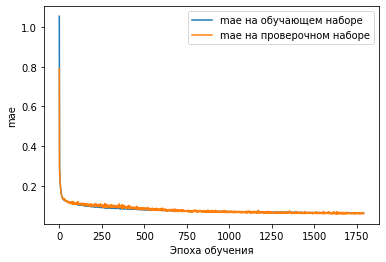

In [150]:
def create_model(input_shape):
  inputs = Input(shape=(input_shape))
  dense = Dense(250, activation='relu')(inputs)
  dense = Dropout(0.2)(dense)
  dense = Dense(250, activation='relu')(dense)
  dense = Dropout(0.2)(dense)
  dense = Flatten()(dense)
  final = Dense(1, activation='linear')(dense)
  model = Model(inputs, final)
  return model

model_name = 'model_vps'

reduce_lr = ReduceLROnPlateau(monitor='val_mae', factor=0.5,
                              patience=90, min_lr=0.000001, verbose=1, mode="min" )
early_stop = EarlyStopping(
    monitor='val_mae', min_delta=0, patience=120, verbose=1,
    mode='min', baseline=None, restore_best_weights=True)

checkpoint = ModelCheckpoint(f'/content/drive/MyDrive/Colab Notebooks/IBS/Models/{model_name}.h5', monitor='val_mae', verbose = 1,
                             save_best_only = True, mode='min')

lr_start = 1e-4
def scheduler(epoch, lr):
  if epoch % 500 == 0:
    return lr_start
  else:
    return lr

lr_schedule = tf.keras.callbacks.LearningRateScheduler(scheduler)

model = create_model((X_filter.shape[1],1))
model.compile(loss='mse', optimizer=Adam(learning_rate=lr_start),  metrics=['mae'])

#Запускаем обучение
history = model.fit( X_filter, np.array(y), 
                    epochs=10000,
                    batch_size=500,
                    verbose=1, 
                    validation_split=0.15,
                    callbacks=[reduce_lr, early_stop, checkpoint, tensorboard_callback, lr_schedule],
                    )

plt.plot(history.history['mae'], 
         label='mae на обучающем наборе')
plt.plot(history.history['val_mae'], 
         label='mae на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('mae')
plt.legend()
plt.show()

In [151]:
print('mae:', round(mae(X_val_filter, np.array(y_val), model), 3))
print('mean_val:', np.mean(np.array(y_val)))
print('% error:', round(mae(X_val_filter, np.array(y_val), model) /  np.mean(np.array(y_val)), 3))

mae: 0.06
mean_val: 1.2104984365228268
% error: 0.05


In [153]:
%tensorboard --logdir logs

ERROR: Failed to launch TensorBoard (exited with 2).
Contents of stderr:
2021-05-31 19:36:56.314137: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
usage: tensorboard [-h] [--helpfull] {serve,dev} ...
tensorboard: error: invalid choice: '/content/drive/MyDrive/Colab Notebooks/IBS/logs/' (choose from 'serve', 'dev')

In [ ]:
!